# 1. Imports

In [1]:
# our functions
import functions as f
# readers

import gzip
import json

import codecs

import numpy as np

import random

In [2]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"

# 2. Read in the files

In [3]:
train = f.readJson(PATH["music_reviews_train"])
dev = f.readJson(PATH["music_reviews_dev"])
test = f.readJson(PATH["music_reviews_test"])

Number of data:  100000
Number of data:  10000
Number of data:  10000


In [4]:
sent_dict = {"positive": 1, "negative": 0}

In [5]:
# read the train data
data = train
train_sent = []
train_sentiment = []
train_idx = []
missing_indexies = []
y_train = []
length_of_sentencies_counter = []
for i in range(len(data)):
    try:
        train_sent.append(data[i]["reviewText"])
        train_sentiment.append(data[i]["sentiment"])
        train_idx.append(i)
        y_train.append(sent_dict[data[i]["sentiment"]])
        length_of_sentencies_counter.append(len(data[i]["reviewText"].split()))
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

[4603, 4838, 16019, 18229, 19785, 23315, 28397, 28834, 33359, 43138, 43539, 43690, 44008, 44477, 44972, 48811, 49317, 50106, 51717, 52286, 55555, 56171, 57223, 58328, 58799, 58866, 59525, 59739, 61046, 61914, 61916, 62831, 63208, 72268, 78944, 79067, 80093, 80637, 80658, 81640, 81900, 82510, 83138, 83145, 83615, 84761, 87112, 88895, 88984, 89132, 91949, 94301, 94727, 99641]


number of words in the sentence
47.03345806735637


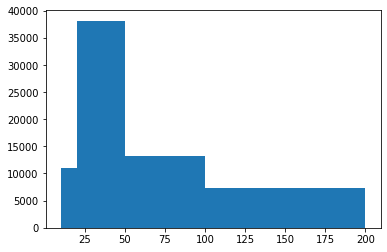

In [6]:
# train data reviews length simple statistic
import matplotlib.pyplot as plt
plt.hist(length_of_sentencies_counter, bins = [10, 20, 50,100,200])
print("number of words in the sentence")
print(np.average(length_of_sentencies_counter))

(array([9.9217e+04, 6.1500e+02, 8.3000e+01, 1.7000e+01, 8.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.0000e+00, 4.6530e+02, 9.2960e+02, 1.3939e+03, 1.8582e+03,
        2.3225e+03, 2.7868e+03, 3.2511e+03, 3.7154e+03, 4.1797e+03,
        4.6440e+03]),
 <BarContainer object of 10 artists>)

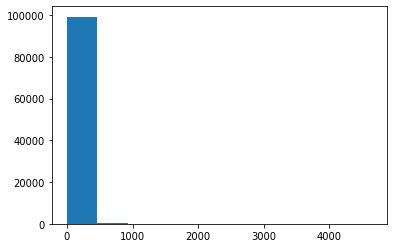

In [7]:
plt.hist(length_of_sentencies_counter)

In [8]:
data = dev
dev_sent = []
dev_sentiment = []
dev_idx = []
missing_indexies = []
dev_y_train = []
for i in range(len(data)):
    try:
        dev_sent.append(data[i]["reviewText"])
        dev_sentiment.append(data[i]["sentiment"])
        dev_idx.append(i)
        dev_y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

[2900, 4294, 5135, 8540]


In [9]:
data = test
test_sent = []
test_sentiment = []
test_idx = []
missing_indexies = []
for i in range(len(data)):
    try:
        test_sent.append(data[i]["reviewText"])
        test_sentiment.append(data[i]["sentiment"])
        test_idx.append(i)
        #y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        missing_indexies.append(i)
        continue
print("index of reviews which are empty: ",missing_indexies)

[90, 117, 439, 2138, 4112, 5364, 8210]


In [10]:
# it needs to be replaced since it doesnt handle the lower/upper cases and the mess
###################################################################################
from zeugma import TextsToSequences
sequencer = TextsToSequences()
sequencer.fit_transform(train_sent)
#print(sequencer.index_word)
# fit new data 
Train = sequencer.transform(train_sent)
Dev = sequencer.transform(dev_sent)
Test = sequencer.transform(test_sent)

c:\users\music\appdata\local\programs\python\python39\lib\site-packages\zeugma\keras_transformers.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
def sequence_pad(sequence, padding='pre', maxlen=50):
    res = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=maxlen,
        dtype='int32',
        padding=padding,
        truncating='pre',
        value=0.0)
    return res

In [13]:
padding = "post"
maxlen = 50
X_train_p = sequence_pad(Train, padding=padding, maxlen=maxlen)
X_dev_p = sequence_pad(Dev, padding=padding, maxlen=maxlen)
X_test_p = sequence_pad(Test, padding=padding, maxlen=maxlen)
len(X_test_p)

9993

In [14]:
X_train_m = np.array(X_train_p)
y_train_m = np.array(y_train)
print(len(y_train_m))
print(len(X_train_m))
X_valid_m = np.array(X_dev_p)
y_valid_m = np.array(dev_y_train)
print(len(X_valid_m))
print(len(y_valid_m))
X_test_m = np.array(X_test_p)
#y_test_m = np.array(y_test)
print(len(X_test_m))
#print(len(y_test_m))

bias = 10000

ran = random.randint(0, len(X_train_m)-bias)
ran_val = random.randint(0, len(X_valid_m)-(bias/10))
s_tr = ran
e = ran+bias
s_test = ran_val
e_test = ran_val+(bias/10)

X_train_m = X_train_m[s_tr:e]
y_train_m = y_train_m[s_tr:e]
X_valid_m = X_valid_m[s_test:int(e_test)]
y_valid_m = y_valid_m[s_test:int(e_test)]
#X_valid_m = X_valid_m[s:e]
#y_valid_m = y_valid_m[s:e]
print(len(y_train_m))
print(len(X_train_m))

99946
99946
9996
9996
9993
10000
10000


In [ ]:
vocabulary_size = max(sequencer.index_word)

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size=64
model=Sequential()
model.add(Embedding(vocabulary_size+1, embedding_size, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

batch_size = 16
num_epochs = 8

#X_valid, y_valid = X_train_k[batch_size:], y_train[batch_size:]
history = model.fit(X_train_m, y_train_m, validation_data=(X_valid_m, y_valid_m), batch_size=batch_size, epochs=num_epochs)
#history = model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_trainn, y_trainn, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
pyplot.plot(history.history["accuracy"], label='train accuracy')
pyplot.plot(history.history["loss"], label='train loss')
pyplot.plot(history.history["val_loss"], label='validation loss')
pyplot.plot(history.history["val_accuracy"], label='validation accuracy')
pyplot.legend()
pyplot.show()
######### ------------------------- ################### save the model
#model.save('model/')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            5119488   
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,185,589
Trainable params: 5,185,589
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
625/625 [==============================] - 54s 83ms/step - loss: 0.5856 - accuracy: 0.7186 - val_loss: 0.5632 - val_accuracy: 0.7700
Epoch 2/8
258/625 [===========>..................] - ETA: 30s - loss: 0.4471 - accuracy: 0.7970

### Save the model, prediction

In [ ]:
#model.save('model/')
result = model.predict(X_valid_m)

## Sentiment results, Sampling some guess

In [ ]:

threshold = 0.5
acc = 0
acc_count = 0
res_final = []
for r in result:
    acc_count+=1
    if r<threshold:
        r = 0
        res_final.append("negative")
    if r>threshold:
        res_final.append("positive")
        
for i in random.sample(range(0, 9993), 5):
    print("####", res_final[i], "---", test_sent[i])